Here i am still working on Traning MAMA v1. 

I have previously tried to train MAMA with my 8000 dataset right from the foundation but it kept overfitting

So now, i am going to do Transfer Learning usinG DistilBERT since my current computational power is low. Since DistilBERT was specifically designed to 

be smaller, faster, and lighter than the original BERT. It has roughly 40% fewer parameters (66 million vs. BERT-base's 110 million, and still maintaince 97 percent of its performance) and is 

significantly faster for both training and inference (up to 60% faster). This means it will train much quicker on my laptop, and require less memory.

Also, i am going to use DistilBERT Cased because i am going to be applying NER to my model later

In [7]:

from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import string
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv(r"C:\Users\WAJI\OneDrive\projects\MAMA\MAMA v1 STEP 2\MAMADATA.csv")   #Loading my dataset


In [9]:
df.head()
df["Statement"].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
16157    False
16158    False
16159    False
16160    False
16161    False
Name: Statement, Length: 16162, dtype: bool

DATA CLEANING

In [10]:
df["Statement"] = df["Statement"].str.lower()                                             #Turning phrases into lowercase
df['Statement'] = df['Statement'].astype(str).apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))  #Removing punctuations

df["Intent"].value_counts()


df.loc[df["Intent"] == " Excitement", "Intent"] = "Excitement"
df.loc[df["Intent"] == " Complaint", "Intent"] = "Complaint"
df.loc[df["Intent"] == "Inmitation", "Intent"] = "Imitation"
df.loc[df["Intent"] == "Reqeust", "Intent"] = "Question"
df.loc[df["Intent"] == "Possesion", "Intent"] = "Possession"
df.loc[df["Intent"] == "Excitemenmt", "Intent"] = "Excitement"
df.loc[df["Intent"] == "Obsevation", "Intent"] = "Observation"
df.loc[df["Intent"] == "observation", "Intent"] = "Observation"
df.loc[df["Intent"] == "Inquiry", "Intent"] = "Question"
df.loc[df["Intent"] == "Obvservation", "Intent"] = "Observation"
df.loc[df["Intent"] == "Accomplishment", "Intent"] = "Pride"
df.loc[df["Intent"] == "complaint", "Intent"] = "Complaint"
df.loc[df["Intent"] == "attention", "Intent"] = "Attention"
df.loc[df["Intent"] == "inquiry", "Intent"] = "Question"
df.loc[df["Intent"] == "pride", "Intent"] = "Pride"
df.loc[df["Intent"] == "assertion", "Intent"] = "Command"
df.loc[df["Intent"] == "Affection", "Intent"] = "Comfort"
df.loc[df["Intent"] == "Suggestion", "Intent"] = "Observation"
df.loc[df["Intent"] == "frustration", "Intent"] = "Emotion"
df.loc[df["Intent"] == "Reaction", "Intent"] = "Observation"
df.loc[df["Intent"] == "question", "Intent"] = "Question"
df.loc[df["Intent"] == "command", "Intent"] = "Command"
df.loc[df["Intent"] == "emotion", "Intent"] = "Emotion"
df.loc[df["Intent"] == "request", "Intent"] = "Request"
df.loc[df["Intent"] == "Dislike", "Intent"] = "Complaint"
df.loc[df["Intent"] == "Fear", "Intent"] = "Distress"
df.loc[df["Intent"] == "imitation", "Intent"] = "Imitation"
df.loc[df["Intent"] == "reaction", "Intent"] = "Observation"
df.loc[df["Intent"] == "need", "Intent"] = "Need"
df.loc[df["Intent"] == "Frustration", "Intent"] = "Emotion"
df.loc[df["Intent"] == "Hurt", "Intent"] = "Distress"
df.loc[df["Intent"] == "Assistance", "Intent"] = "Question"
df.loc[df["Intent"] == "Intent", "Intent"] = "Distress"
df.loc[df["Intent"] == "Request", "Intent"] = "Question"

df.loc[df["Intent"] == "Pcitement!", "Intent"] = "Excitement"
df.loc[df["Intent"] == "Pitation", "Intent"] = "Imitation"
df.loc[df["Intent"] == "Cmand", "Intent"] = "Command"
df.loc[df["Intent"] == "Excitement!", "Intent"] = "Excitement"




df["Intent"].value_counts()









Intent
Comfort        1181
Pride          1165
Observation    1048
Emotion        1041
Distress       1035
Imitation      1018
Command        1011
Need           1009
Desire         1007
Possession     1004
Complaint       999
Attention       995
Excitement      989
Refusal         922
Question        914
Gratitude       824
Name: count, dtype: int64

In [11]:
#Now i am going to label "Intent" category so that each category is represented with a label/Number

label_encoder =LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Intent"])


#Now i am going to check the label mapping
intent_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Intent Label Mapping:", intent_mapping)

Intent Label Mapping: {'Attention': np.int64(0), 'Comfort': np.int64(1), 'Command': np.int64(2), 'Complaint': np.int64(3), 'Desire': np.int64(4), 'Distress': np.int64(5), 'Emotion': np.int64(6), 'Excitement': np.int64(7), 'Gratitude': np.int64(8), 'Imitation': np.int64(9), 'Need': np.int64(10), 'Observation': np.int64(11), 'Possession': np.int64(12), 'Pride': np.int64(13), 'Question': np.int64(14), 'Refusal': np.int64(15)}


Now i know that:

Attention takes 0

Comfort 1

Command 2

Complaint 3

Desire 4

Distress 5

Emotion 6

Excitement 7

Gratitude 8

Imitation 9

Need 10

Observation 11

Possession 12

Pride 13

Question 14

Refusal 15


USING TRANSFORMER NOW


In [12]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")

#Tokenzing all statements
encodings = tokenizer(
    df["Statement"].tolist(),       #Converts the column statements to a list of sentences
    truncation = True,              #Ensure long sentences are cut off at the 64th word
    padding = True,                 #Helps me adds oadding so shorter sentences all have the same length
    max_length = 64,                #Setting my truncating to 64
    return_tensors = "tf"           #Helps me convert the data into friendly tensorflow format
)

#Now conveting labels to tensors
labels = tf.convert_to_tensor(df["Label"].tolist())


Now, i am going to Prepare my dataset for training by converting Tokenized inputs and labels into what Tensorflow can work with

tf.data.Dataset


In [13]:
#Creating a tensorflow dataset

dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings), labels
))

dataset = dataset.shuffle(1000, seed = 42)   #Here i am shuffling every 1000 data before training so the model doesnt learn the patter due to arrangement
train_size = int(0.8 * len(dataset))         #Here  i want to use 80 percent of my data for training


train_dataset = dataset.take(train_size).batch(16)  #Takes 80 percent of the data for training
val_dataset = dataset.skip(train_size).batch(16)    #Then skip to the last 20 percent fpr validation


#from_tensor_slices takes 2 inputs:
#Encodings are tokenized words from DistilBert
#Labels are the coreect answers for each sentence in my dataset
#dict(encodings) converts tokenized sentences into dictionary making it usable for tensorflow
#batch(16), instead of training 1 example at a time, it takes 16 at once to save time during training


In [ ]:
NOW I AM GOING TO LOAD AND CONFIGURE DistilBert MODEL FOR CLASSIFICATION


In [14]:
labels = df["Intent"].unique()

#Creating label2id and id2label dictionaries
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(label2id)
print(id2label)


{'Command': 0, 'Comfort': 1, 'Complaint': 2, 'Imitation': 3, 'Need': 4, 'Gratitude': 5, 'Emotion': 6, 'Refusal': 7, 'Possession': 8, 'Pride': 9, 'Attention': 10, 'Desire': 11, 'Distress': 12, 'Observation': 13, 'Excitement': 14, 'Question': 15}
{0: 'Command', 1: 'Comfort', 2: 'Complaint', 3: 'Imitation', 4: 'Need', 5: 'Gratitude', 6: 'Emotion', 7: 'Refusal', 8: 'Possession', 9: 'Pride', 10: 'Attention', 11: 'Desire', 12: 'Distress', 13: 'Observation', 14: 'Excitement', 15: 'Question'}


In [15]:

# Number of intent labels (from your label mapping)
num_labels = len(label2id)

# Load the DistilBERT model for classification
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

#label2id  works just like LabelEncoder
#id2label is the reverse of my coversion which usually creates awareness of my custom labels for my model 

"""
I am using those because Hugging Face models expect a label2id dictionary and internally handle label mapping.
This is more explicit and controllable, which is important when you want the output labels to match  real-world 
use case (like MAMA knowing what “Command” means and not just the numerical representation).
"""

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

'\nI am using those because Hugging Face models expect a label2id dictionary and internally handle label mapping.\nThis is more explicit and controllable, which is important when you want the output labels to match  real-world \nuse case (like MAMA knowing what “Command” means and not just the numerical representation).\n'

COMPILING THE MODEL

In [16]:
optimizer = tf.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


#I included from_logits = True because the model final layers gives me raw score and not probabilities
#That tells Tensorflow to help me handle it correctly

TRANING THE MODEL

In [17]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 3
)


#Here, i started with 3 epochs since i am not training the model from scratch, DistilBert is already and intelligent reader

Epoch 1/3


809/809 [==============================] - 863s 1s/step - loss: 0.7869 - accuracy: 0.7689 - val_loss: 0.4049 - val_accuracy: 0.8815
Epoch 2/3
809/809 [==============================] - 842s 1s/step - loss: 0.3522 - accuracy: 0.8946 - val_loss: 0.3399 - val_accuracy: 0.9013
Epoch 3/3
809/809 [==============================] - 859s 1s/step - loss: 0.2670 - accuracy: 0.9172 - val_loss: 0.2926 - val_accuracy: 0.9156


In [ ]:
PLOTTING TO TELL THE VISUAL STORY

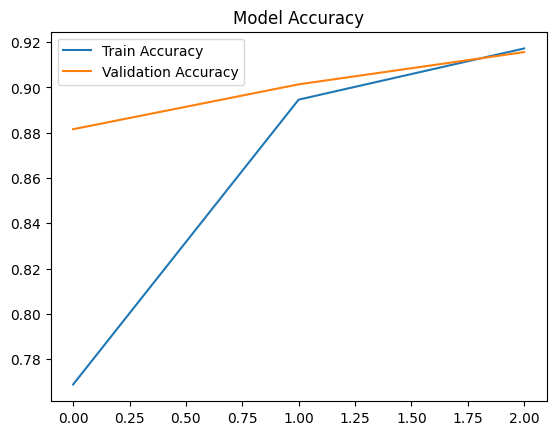

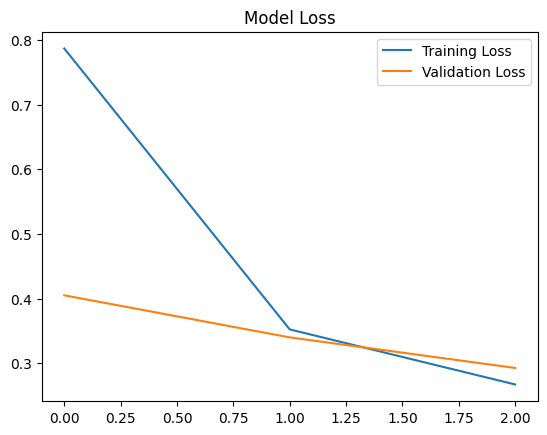

In [18]:
#Accuracy
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()


#Loss
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Model Loss")
plt.legend()
plt.show()


INTERPRETATION OF OLD TRAINING (DELETED BY MISTAKE)

My training performance kept going up
MY validation was increasing too but not as fast as traning accuracy

NB: I usually want the space between both Training and Validation to be close, which indicates that my model is learning from the data and also my
validation is staying very close to it

If i had trained longer, maybe using more epochs, the space between both lines would have gotten wider, which would indicate my model
was just memorizing and not learning general patterns

My validation accuracy peaked and stopped at 80% accuracy, thats a very good performance. But considering the nature of MAMA and what its real-life performance is going to be, what if it misunderstands 1 out of 5 things information passed to it? This might not really be a good thing especially working with children

(###I MISTAKENLY DELETED THE FORMER TRAINING)







INTERPRETATION OF NEW TRAINING (THE ONE YOU CAN SEE NOW)

More data was gathered, and then there was an increased performance for MAMA, it accounted for 91 percent accuracy which means MAMA is not memorizing data
but very good at generalizing unseen data. 91% is a very good performance and solid for language understanding mode, so this would be kept

NOW I AM GOING TO SAVE MY MODEL AND TOKENIZER FOR TESTING AND DEPLOYMENT

In [87]:
model_path = "MAMA_v1_distilbert_model"
tokenizer_path = "MAMA_v1_tokenizer"

model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('MAMA_v1_tokenizer\\tokenizer_config.json',
 'MAMA_v1_tokenizer\\special_tokens_map.json',
 'MAMA_v1_tokenizer\\vocab.txt',
 'MAMA_v1_tokenizer\\added_tokens.json')

In [19]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
import tensorflow as tf
import pandas as pd
import numpy as np

In [20]:
model = TFDistilBertForSequenceClassification.from_pretrained("MAMA_v1_distilbert_model")
tokenizer = DistilBertTokenizer.from_pretrained("MAMA_v1_tokenizer")

Some layers from the model checkpoint at MAMA_v1_distilbert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_99']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at MAMA_v1_distilbert_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def predict_intent(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=64)

    # Run through model
    outputs = model(inputs)
    logits = outputs.logits

    # Pick highest score
    predicted_label = tf.argmax(logits, axis=1).numpy()[0]

    # Translate integer back to intent name
    intent_name = id2label[predicted_label]
    
    return intent_name




In [ ]:
while True:
    user_input = input("👶 What does the toddler say? (or type 'exit' to stop): ")
    if user_input.lower() == "exit":
        break
    intent = predict_intent(user_input)
    print(f"🤖 MAMA thinks the intent is: **{intent}**\n")


👶 What does the toddler say? (or type 'exit' to stop):  I am so happy today


🤖 MAMA thinks the intent is: **Emotion**



👶 What does the toddler say? (or type 'exit' to stop):  I am so excited to be here


🤖 MAMA thinks the intent is: **Refusal**



👶 What does the toddler say? (or type 'exit' to stop):  Yay Daddy


🤖 MAMA thinks the intent is: **Refusal**



👶 What does the toddler say? (or type 'exit' to stop):  I dont want to do this


🤖 MAMA thinks the intent is: **Question**



👶 What does the toddler say? (or type 'exit' to stop):  Ask me any question of your choice


🤖 MAMA thinks the intent is: **Command**



👶 What does the toddler say? (or type 'exit' to stop):  Thanks for gifting me this


🤖 MAMA thinks the intent is: **Possession**



👶 What does the toddler say? (or type 'exit' to stop):  Thanks sir


🤖 MAMA thinks the intent is: **Possession**



👶 What does the toddler say? (or type 'exit' to stop):  I need to leave


🤖 MAMA thinks the intent is: **Attention**



In [ ]:

NOW THERE IS A PROBLEM.
From what i can see from the training, my model trained well and the validation accuracy was on point which is 91%. Thats actually a very good score
for NLP project. 
Then testing my model with an input, it mislabelled the inputs even though it had good generalization during training.

I cant think of anything at the moment besides my "Dataset". Could my data be the reason why real-life inputs were so off ?.
I am going to do some further research and see what can be done.

